In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from os.path import join
import os
import xarray as xr

import crime_patterns.utilities as utils
import crime_patterns.config as config
import crime_patterns.data_management as dm

from crime_patterns.final import plotting
from crime_patterns.analysis import point_patterns 

%load_ext autoreload
%autoreload 2

c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
c:\Users\Mumu\miniconda3\envs\crime_patterns\Lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
src = config.SRC
bld = config.BLD
data_raw = src / "data"
data_clean = bld / "python" / "data"
results_dir = bld / "python" / "results" 
plots_dir = bld / "python" / "figures"

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(plots_dir):
    os.makedirs(plots_dir)

In [4]:
ds = xr.open_dataset(r"C:\Users\Mumu\Desktop\Bonn Econ\Winter22-23\EPP\crime_patterns\bld\python\results\kernel_density_estimates.nc")

In [9]:
ds.close() #["lon"].values

In [3]:
## define paths
shapefiles_dir = os.path.join(data_raw, "statistical-gis-boundaries-london", "statistical-gis-boundaries-london", "ESRI")
london_ward_shp_path = os.path.join(shapefiles_dir, "London_Ward.shp")
london_borough_shp_path = os.path.join(shapefiles_dir, "London_Borough_Excluding_MHW.shp")
london_lsoa_shp_path = os.path.join(shapefiles_dir, "LSOA_2011_London_gen_MHW.shp")
london_greater_area_shp_path = os.path.join(data_clean,  "Greater_London_Area.shp")

crime_incidences_path = os.path.join(data_clean, r"city-of-london-burglaries-2019-cleaned.csv") 
imd_shp_path = os.path.join(data_raw, r"IMD_LSOA_2019\IMD_2019.shp")

In [4]:
london_lsoa = gpd.read_file(london_lsoa_shp_path)
london_ward = gpd.read_file(london_ward_shp_path)
london_borough = gpd.read_file(london_borough_shp_path)
london_greater_area = gpd.read_file(london_greater_area_shp_path)
imd = gpd.read_file(imd_shp_path)

In [5]:
## Load data
crime_incidences = pd.read_csv(crime_incidences_path)

#### Analysis

In [6]:
densities = point_patterns.evaluate_hotspots(longitudes=crime_incidences["Longitude"], latitudes=crime_incidences["Latitude"], region=london_greater_area)

In [7]:
densities.to_netcdf(os.path.join(results_dir, "kernel_density_estimates.nc"), mode='w', format="NETCDF4", engine="netcdf4")

In [8]:
with xr.open_dataset(os.path.join(results_dir, "kernel_density_estimates.nc")) as densities:
    
    densities.load()

In [9]:
X_coords, Y_coords, densities = densities["lon"].to_numpy(), densities["lat"].to_numpy(), densities["densities"].to_numpy()

In [10]:
densities

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [11]:
dbscan = point_patterns.cluster_crime_incidents_dbscan(
                        latitudes=crime_incidences["Latitude"],
                        longitudes=crime_incidences["Longitude"],
                        epsilon=1.5, # km
                        min_samples=330,
                        )

In [12]:
labels = dbscan.labels_

In [13]:
utils.save_object_to_pickle(dbscan, os.path.join(results_dir, "dbscan.pickle"))

'C:\\Users\\Mumu\\Desktop\\Bonn Econ\\Winter22-23\\EPP\\crime_patterns\\bld\\python\\results\\dbscan.pickle'

In [14]:
dbscan = utils.load_object_from_pickle(os.path.join(results_dir, "dbscan.pickle"))

#### Plotting

In [15]:
# Setup figure and axis
height = 8
width = height*0.75

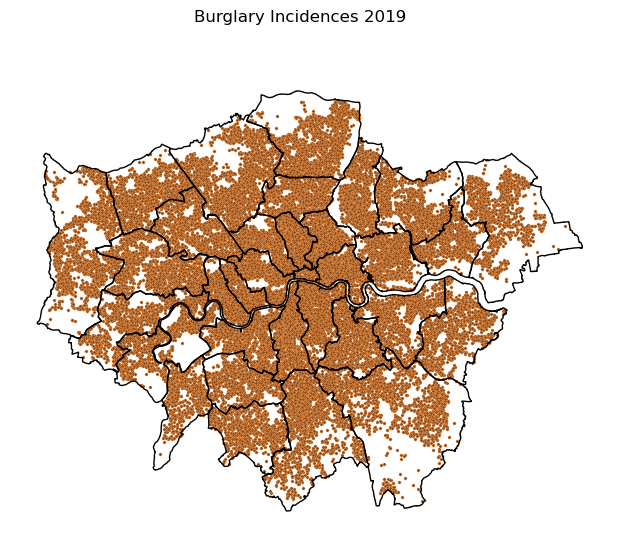

In [16]:
fig, ax = plotting.plot_crime_incidents(crime_incidences["Longitude"], crime_incidences["Latitude"], london_borough, figsize=(height, width))

plt.suptitle("Burglary Incidences 2019")
fig.savefig(os.path.join(plots_dir, 'burglary_incidents.png'), dpi=300, bbox_inches='tight')

In [ ]:
fig, ax, cbar = plotting.plot_hotspots(X_coords, Y_coords, densities, london_borough, figsize=(height, width))

cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("Density (KDE)", rotation=270)

plt.suptitle("Burglary Hotspots")
plt.savefig(os.path.join(plots_dir, 'burglary_hotspots.png'), dpi=300, bbox_inches='tight')

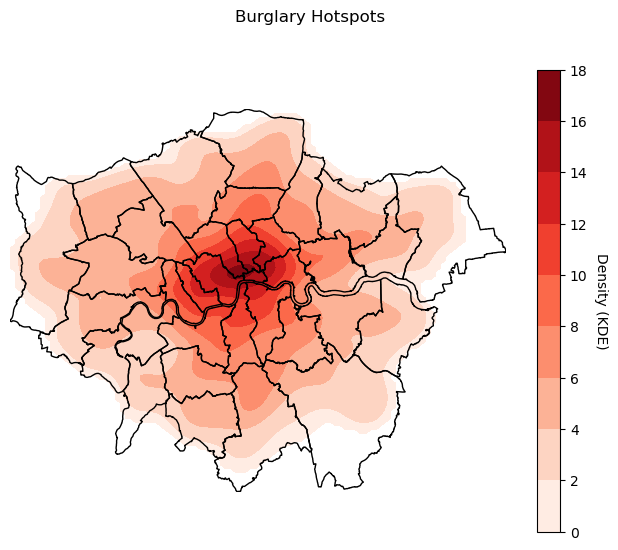

In [17]:
fig, ax, cbar = plotting.plot_hotspots(X_coords, Y_coords, densities, london_borough, figsize=(height, width))

cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("Density (KDE)", rotation=270)

plt.suptitle("Burglary Hotspots")
plt.savefig(os.path.join(plots_dir, 'burglary_hotspots_transparent.png'), dpi=300, bbox_inches='tight', transparent=True)

In [ ]:

fig, ax = plotting.plot_dbscan_clusters(crime_incidences, labels, london_borough, figsize=(height, width))

ax.legend(bbox_to_anchor = (0, 0.5))
plt.suptitle("Clustered Burglary Incidences (DBCAN)")

fig.savefig(os.path.join(plots_dir, 'burglary_clusters.png'), dpi=300, bbox_inches='tight')

<Axes: >

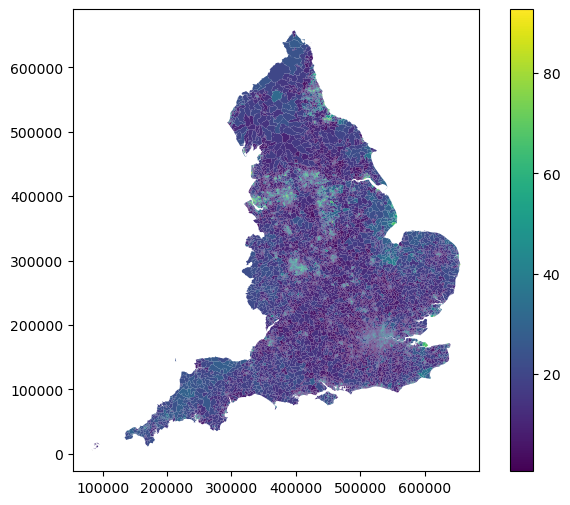

In [15]:
imd.plot(column="IMDScore", figsize=(height, width), legend=True)

In [20]:
join = imd.sjoin(london_lsoa.to_crs(imd.crs), how="inner")

In [28]:
london_lsoa

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,96,227.7,817,1.5,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,0,52.0,467,2.1,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,4,116.2,543,3.1,"POLYGON ((545122.049 184314.931, 545271.917 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,E01033742,Greenwich 007F,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1352,1352,0,107.6,581,2.3,"POLYGON ((544642.680 179824.674, 544766.313 17..."
4831,E01033743,Greenwich 002H,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,2038,2038,0,20.4,663,3.1,"POLYGON ((546579.195 181097.813, 546687.036 18..."
4832,E01033744,Greenwich 007G,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1845,1728,117,125.8,646,2.7,"POLYGON ((544536.486 179447.115, 544602.630 17..."
4833,E01033745,Greenwich 002I,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,1820,1820,0,32.3,591,3.1,"POLYGON ((546415.745 180152.270, 546320.715 18..."


In [35]:
join_grouped = london_lsoa.merge(join.groupby(by='lsoa11cd').mean(), left_on='LSOA11CD', right_on='LSOA11CD'.lower(), how='inner')

C:\Users\Mumu\AppData\Local\Temp\ipykernel_14636\943420664.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  join_grouped = london_lsoa.merge(join.groupby(by='lsoa11cd').mean(), left_on='LSOA11CD', right_on='LSOA11CD'.lower(), how='inner')


In [36]:
type(join_grouped)

geopandas.geodataframe.GeoDataFrame

Text(0.5, 1.0, 'IMD Score by LSOA')

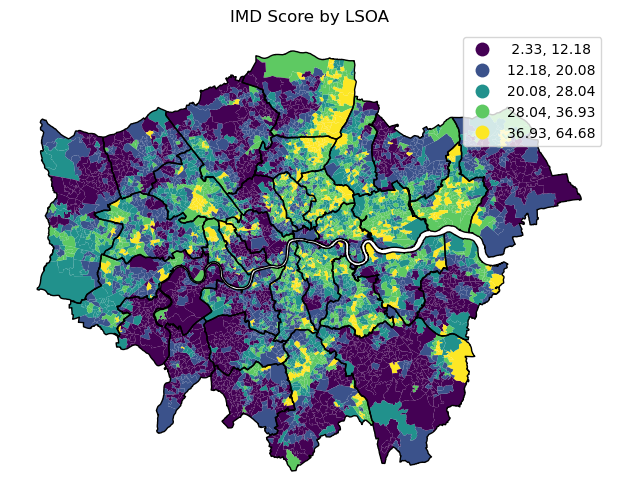

In [45]:

fig, ax = plt.subplots(figsize=(height, width))

choropleth = join_grouped.plot(ax=ax, column="IMDScore", scheme='natural_breaks', legend=True)
# cbar = plt.colorbar(contours)
london_borough.to_crs(imd.crs).plot(ax=ax, fc="None")
plt.axis(False)
ax.set_title("IMD Score by LSOA")


In [ ]:
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("Density (KDE)", rotation=270)